# Bank Notes Anomaly Detection 

---
## Objective
This analysis focuses on authenticating banknotes using machine learning techniques. The dataset contains features extracted from images of genuine and forged banknotes, with the goal of identifying patterns and anomalies that distinguish real from fake currency.

## Dataset
Data were extracted from images that were taken from genuine and forged banknote-like specimens.  For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.

The dataset consists of 1372 instances with 4 features and a binary class label (0 for genuine, 1 for forged):

### Additional Information on this dataset

1. variance of Wavelet Transformed image (continuous) 
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)

You can download this dataset thru:<br>
**[Banknote Authentication - UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/267/banknote+authentication)**

**NOTE**
This dataset has no missing values

---

In [99]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, f1_score, average_precision_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from scipy.spatial.distance import cdist
from sklearn.neighbors import LocalOutlierFactor

In [2]:
#Load the dataset
columns = ['variance', 'skewness', 'kurtosis', 'entropy', 'class']
df = pd.read_csv('data_banknote_authentication.txt', header=None, names=columns)
df.head()

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
df.shape

(1372, 5)

In [4]:
df.isnull().sum()

variance    0
skewness    0
kurtosis    0
entropy     0
class       0
dtype: int64

In [5]:
df.dtypes

variance    float64
skewness    float64
kurtosis    float64
entropy     float64
class         int64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   kurtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [7]:
df.describe()

,variance,skewness,kurtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


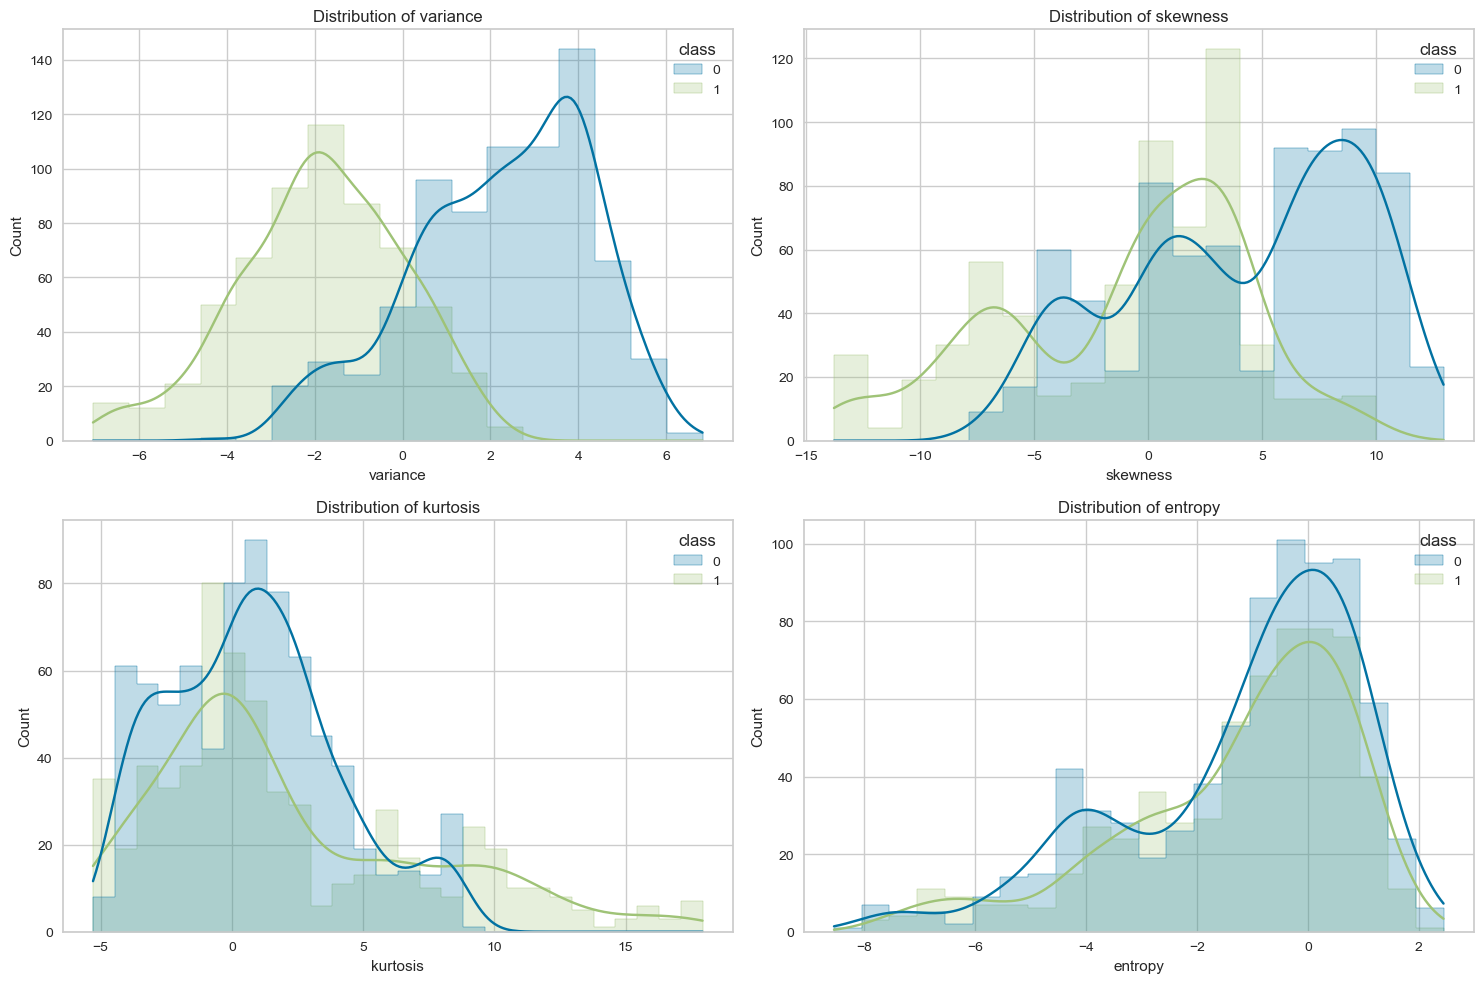

In [8]:
# Visualize feature Distributions (variance, skewness, kurtosis, enthropy)
plt.figure(figsize=(15,10))

for i, col in enumerate(df.columns[:-1]):
    plt.subplot(2,2, i+1)
    sns.histplot(data=df, x=col, hue='class',kde=True, element='step')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [9]:
plt.savefig('Feature_Distributions.png')

<Figure size 800x550 with 0 Axes>

### Insights:

>All Features show distinct patterns between classes

>Variance and curtosis appear most discriminative

>The clear separations explain why classification models achieve near-perfect accuracy

>Some features like skewness show non-normal distributions that might benefit from transformations

## Correlation Matrix

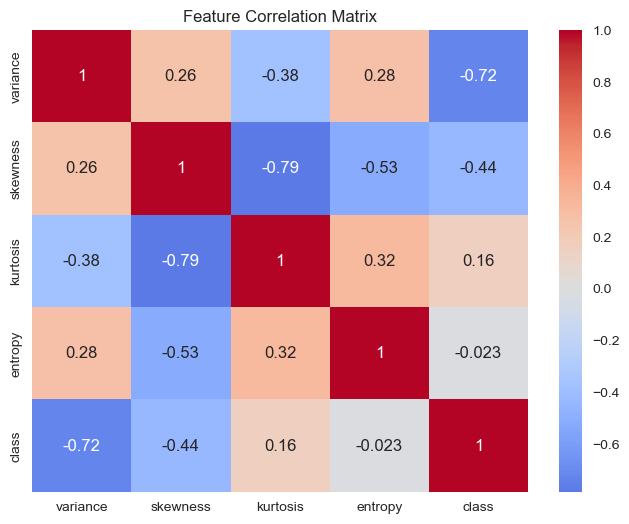

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [11]:
plt.savefig('correlation_matrix.png')

<Figure size 800x550 with 0 Axes>

### Insight
* Variance is the strongest indicator of class (genuine or counterfeit), with a strong negative correlation. As variance increases, the likelihood of being a counterfeit note decreases (or vice versa).

* Skewness also plays a significant role but is less influential than variance.

* Kurtosis and Entropy show low to negligible correlation with the target, even though entropy had high PCA loading—indicating it helps explain variance, but not directly related to the class.


In [12]:
#Standardized the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.iloc[:, :-1])
y=df['class']

In [13]:
df.iloc[:, :-1]

,variance,skewness,kurtosis,entropy
0,3.62160,8.66610,-2.8073,-0.44699
1,4.54590,8.16740,-2.4586,-1.46210
2,3.86600,-2.63830,1.9242,0.10645
3,3.45660,9.52280,-4.0112,-3.59440
4,0.32924,-4.45520,4.5718,-0.98880
...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949
1368,-1.38870,-4.87730,6.4774,0.34179
1369,-3.75030,-13.45860,17.5932,-2.77710
1370,-3.56370,-8.38270,12.3930,-1.28230


In [14]:
X_scaled

array([[ 1.12180565,  1.14945512, -0.97597007,  0.35456135],
       [ 1.44706568,  1.06445293, -0.89503626, -0.12876744],
       [ 1.20780971, -0.77735215,  0.12221838,  0.61807317],
       ...,
       [-1.47235682, -2.62164576,  3.75901744, -0.75488418],
       [-1.40669251, -1.75647104,  2.552043  , -0.04315848],
       [-1.04712236, -0.43982168,  0.29861555,  1.1364645 ]])

In [15]:
X_scaled.shape

(1372, 4)

## Dimensionality Reduction with PCA

In [16]:
#Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

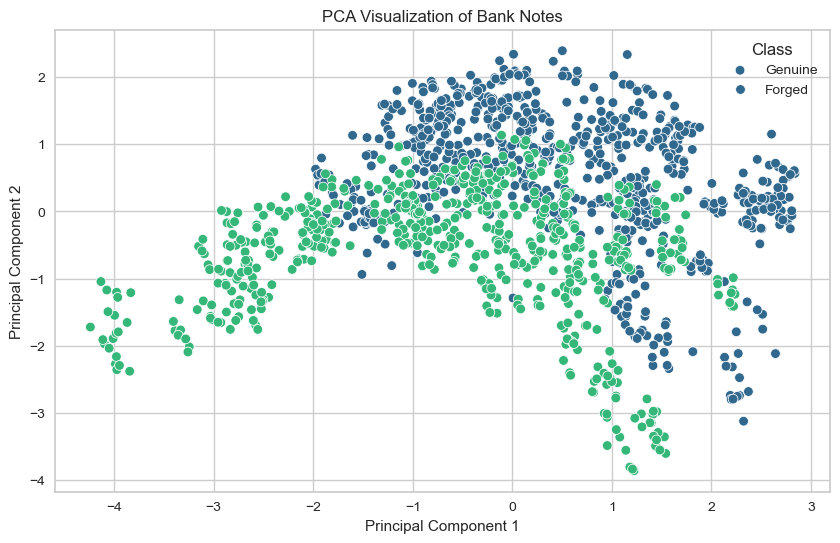

In [17]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
plt.title('PCA Visualization of Bank Notes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class', labels=['Genuine', 'Forged'])
plt.show()

In [18]:
plt.savefig('PCA_Components.png')

<Figure size 800x550 with 0 Axes>

### Insights:

The data appears to form dense groupings with some separation along the principal components, indicating the presence of underlying structure suitable for clustering.
* `Compact Clusters`: The dense concentration of data points suggests that the data has intrinsic groupings even in an unsupervised context.
* `Direction of Spread`: The first principal component captures the direction of highest variance, which likely correlates with features most influential in separating genuine and counterfeit notes.
* `Potential for Clustering`: Even without labels, the formation of distinct clouds in the PCA plot indicates that clustering algorithms (e.g., K-Means, DBSCAN) may be able to uncover natural groupings.
* `Anomaly Visibility`: Outlying points in the scatter may indicate rare or anomalous banknotes that differ significantly from the main distribution, potentially corresponding to counterfeit examples.

### Top 5 features that contributes to the 2 principal components

In [19]:
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC1', 'PC2'],
                        index=['variance', 'skewness', 'curtosis', 'entropy'])

#Compute total contributions to both components
loadings['total_contribution'] = loadings.abs().sum(axis=1)

#Sort by importance
top_features = loadings.sort_values(by='total_contribution', ascending=False)
print('Top Contributing Features to the First 2 Principal Components')
print(top_features.head(5))

Top Contributing Features to the First 2 Principal Components
               PC1       PC2  total_contribution
entropy  -0.392389  0.636010            1.028398
variance  0.248772  0.754591            1.003363
curtosis -0.612707 -0.153459            0.766166
skewness  0.639323 -0.050340            0.689664


Text(0.5, 1.0, 'Feature Loadings on PC1 and PC2')

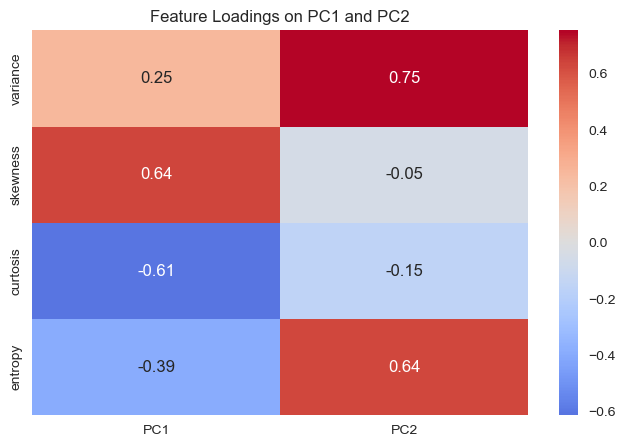

In [20]:
plt.figure(figsize=(8,5))
sns.heatmap(loadings.drop('total_contribution', axis=1),
           annot=True, cmap='coolwarm', center=0)
plt.title('Feature Loadings on PC1 and PC2')

### Insight
>The top features in loadings (likely variance and curtosis) are the most discriminative.

> This aligns with earlier histograms showing clear separation in these features.

In [21]:
plt.savefig('feature_loadings_PC1andPC2.png')

<Figure size 800x550 with 0 Axes>

## Determine the optimal number of clusters

C:\Users\francis\Desktop\machinelearning_project\machinelearningprojects\env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\francis\Desktop\machinelearning_project\machinelearningprojects\env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\francis\Desktop\machinelearning_project\machinelearningprojects\env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\francis\Desktop\machinelearning_project\machinelearningprojects\env\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexe

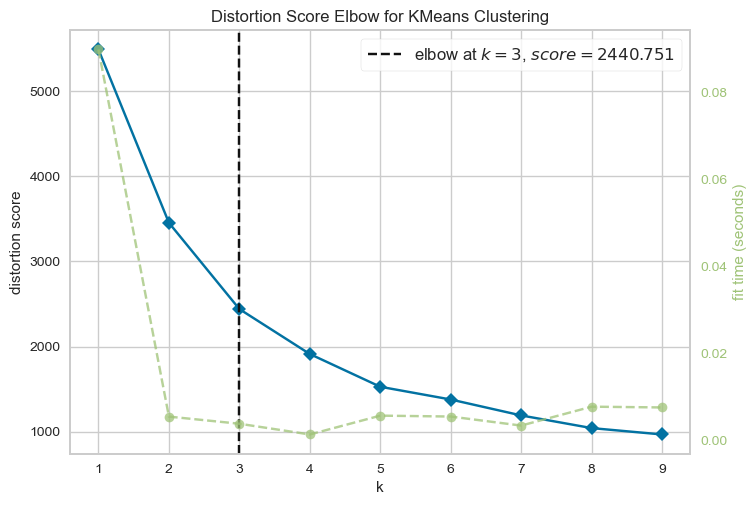

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,10))
visualizer.fit(X_scaled)
visualizer.show()

In [23]:
plt.savefig('Elbow_Score-KMeans.png')

<Figure size 800x550 with 0 Axes>

### Insights
* The elbow point is at k = 3, meaning:

    * Up to k=3: Adding more clusters significantly reduces distortion (better fit).

    * Beyond k=3: The improvement slows down (diminishing returns)
 
* Possible sub-clusters within genuine or forged notes.

* Noise or anomalies causing an extra cluster.

* Overfitting risk if forcing k=3 without domain justification.

### Compare k=2 vs. k=3:

Even though the true labels have 2 classes, the elbow suggests k=3 because:

Feature separation may not be perfectly binary (some forgeries might form a distinct subgroup).

Distortion drops sharply until k=3, meaning a 2-cluster model may miss finer patterns.

**Train K-means with both and inspect cluster characteristics.**

In [24]:
kmeans_2= KMeans(n_clusters=2, random_state=42).fit(X_scaled)
kmeans_3 = KMeans(n_clusters=3, random_state=42).fit(X_scaled)

C:\Users\francis\Desktop\machinelearning_project\machinelearningprojects\env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\francis\Desktop\machinelearning_project\machinelearningprojects\env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


<Axes: >

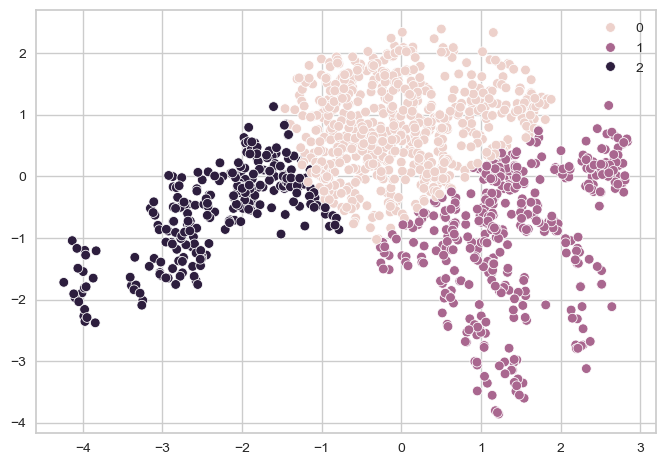

In [25]:
# Visualize Clusters (PCA)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_3.labels_)

In [26]:
plt.savefig('KMeans_Clusters_k=3_results.png')

<Figure size 800x550 with 0 Axes>

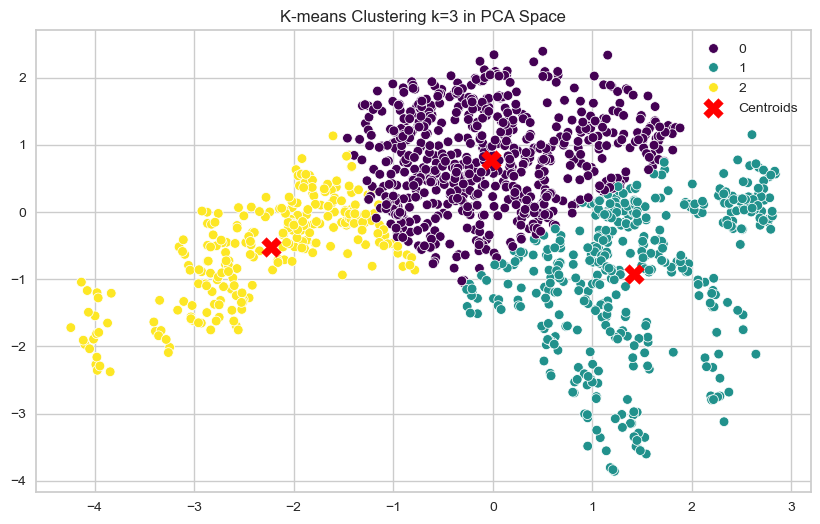

In [27]:
# Plot 3-cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_3.labels_, palette='viridis')
plt.title('K-means Clustering k=3 in PCA Space')

#Annotate clusters centers
centers = pca.transform(kmeans_3.cluster_centers_)
plt.scatter(centers[:, 0], centers[:,1], c='red', marker='X', s=200, label='Centroids')
plt.legend()
plt.show()

In [28]:
plt.savefig('KMeans_Clustering_k=3_with_centroids.png')

<Figure size 800x550 with 0 Axes>

In [29]:
#Compare with True labels
print('Cluster vs. True Label Cross-Tab')
pd.crosstab(df['class'], kmeans_3.labels_)

Cluster vs. True Label Cross-Tab


col_0,0,1,2
class,,,
0,465,232,65
1,214,194,202


### Insights
* Cluster 0: Mixed (465 genuine + 214 forged) → Conflict

* Cluster 1: Mostly forged (232 forged vs. 194 genuine) → Forged-dominant

* Cluster 2: Mixed (65 genuine + 202 forged) → Conflict

**k=3 Overpartitions the Data:**

* The elbow method suggested k=3, but true classes are binary.

* K-means splits genuine notes into two groups (likely due to feature variability).

### Using k=2 to resolve the conflict

In [30]:
pd.crosstab(df['class'], kmeans_2.labels_)

col_0,0,1
class,,
0,410,352
1,254,356


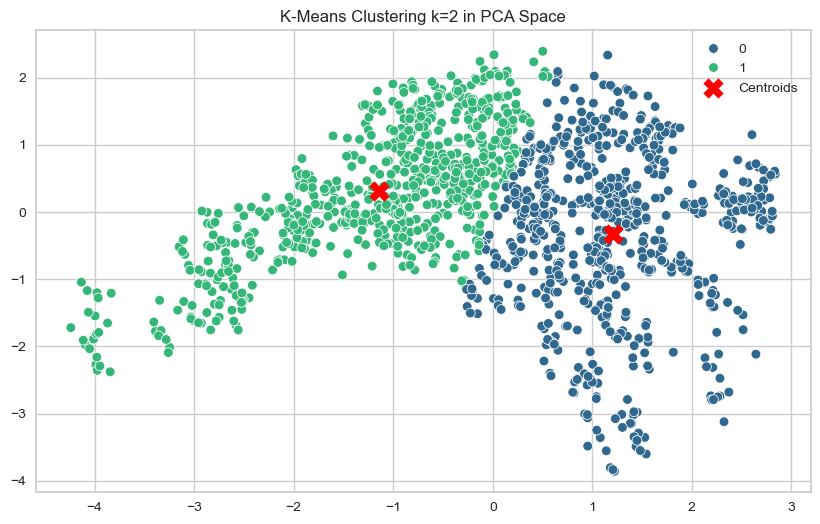

In [31]:
# PLot the KMeans with k=2

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_2.labels_, palette='viridis')
plt.title('K-Means Clustering k=2 in PCA Space')

#Anotate cluster centroids
centers = pca.transform(kmeans_2.cluster_centers_)
plt.scatter(centers[:, 0], centers[:,1], c='red', marker='X', s=200, label='Centroids')
plt.legend()
plt.show()

In [32]:
plt.savefig('KMeans_Clustering_k=2_with_centroids.png')

<Figure size 800x550 with 0 Axes>

In [33]:
# Validate k=2, and k=3 using sihouette score
print(f'Silhouette Score k=2:', silhouette_score(X_scaled, kmeans_2.labels_))
print(f'Silhouette Score k=3:', silhouette_score(X_scaled, kmeans_3.labels_))

Silhouette Score k=2: 0.32905546282355036
Silhouette Score k=3: 0.32707028277614714


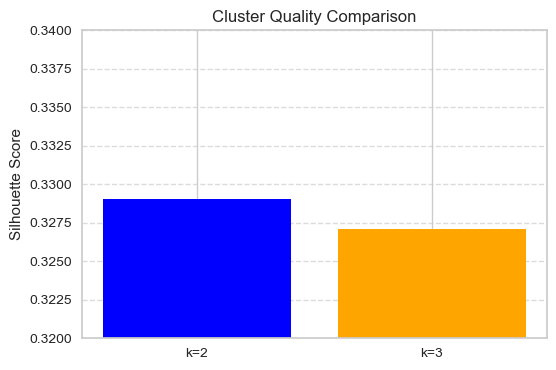

In [34]:
# Plot the silhouette score for visualization
plt.figure(figsize=(6,4))
plt.bar(['k=2', 'k=3'], 
        [silhouette_score(X_scaled, kmeans_2.labels_),silhouette_score(X_scaled, kmeans_3.labels_)],
        color=['blue','orange']
       )
plt.title('Cluster Quality Comparison')
plt.ylabel('Silhouette Score')
plt.ylim(0.32, 0.34)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [35]:
plt.savefig('silhouette_score_k=2vsk=3.png')

<Figure size 800x550 with 0 Axes>

### Insights
* Using k=2 does not overlap clusters
* k=2 captures the dominant structure
* k=2 is functionally equivalent to k=2, since the result emphasizes negligible difference

In [36]:
# KMeans clustering with optimal k
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

C:\Users\francis\Desktop\machinelearning_project\machinelearningprojects\env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [37]:
clusters

array([0, 0, 1, ..., 1, 1, 1])

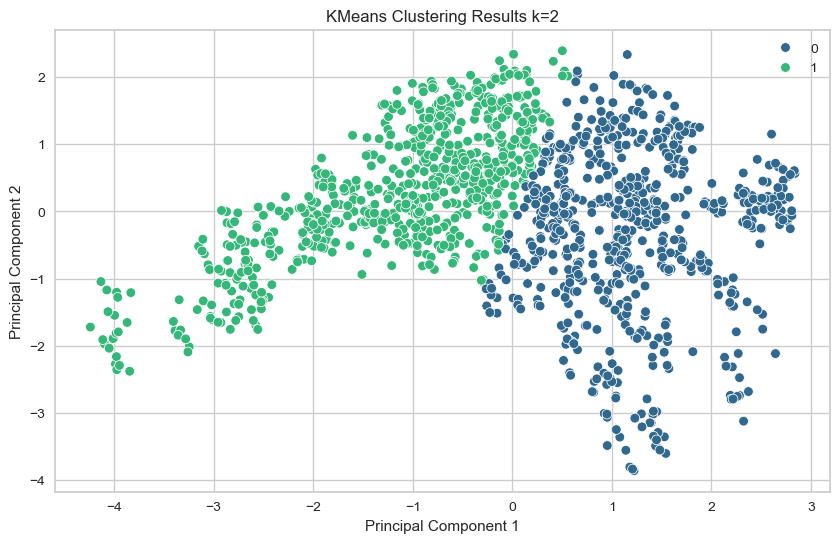

In [38]:
# Plot clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='viridis')
plt.title('KMeans Clustering Results k=2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [39]:
plt.savefig('KMeans_Clustering_Results_k=2.png')

<Figure size 800x550 with 0 Axes>

In [40]:
# Compare clusters with actual Classes
cluster_comparison = pd.DataFrame({'Actual':y, 'Cluster': clusters})
print('\nCluster vs Actual Class Comparison:')
pd.crosstab(cluster_comparison['Actual'], cluster_comparison['Cluster'])


Cluster vs Actual Class Comparison:


Cluster,0,1
Actual,,
0,410,352
1,254,356


## Anomaly Detection Using Isolation Forest

In [41]:
iso_forest = IsolationForest(contamination='auto', random_state=42)
anomalies = iso_forest.fit_predict(X_scaled)

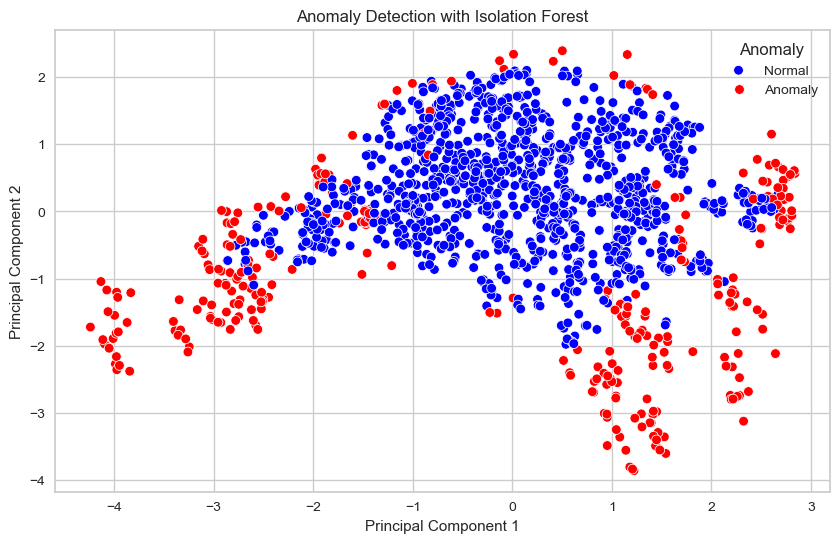

In [42]:
# Plot Anomalies
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:,1],
                hue=anomalies, palette={1: 'blue', -1: 'red'})
plt.title('Anomaly Detection with Isolation Forest')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.show()

In [43]:
pd.crosstab(df['class'], anomalies)

col_0,-1,1
class,,
0,145,617
1,169,441


### Insights
* `145 Genuine anomalies` - it can be misprints or scanning errors
* `169 Forged anomalies` - potentially novel forgery techniques

## Tune Anomaly Detection using contamination 0.1

In [44]:
iso_forest_tuned = IsolationForest(contamination=0.1, random_state=42)
anomalies_tuned = iso_forest_tuned.fit_predict(X_scaled)

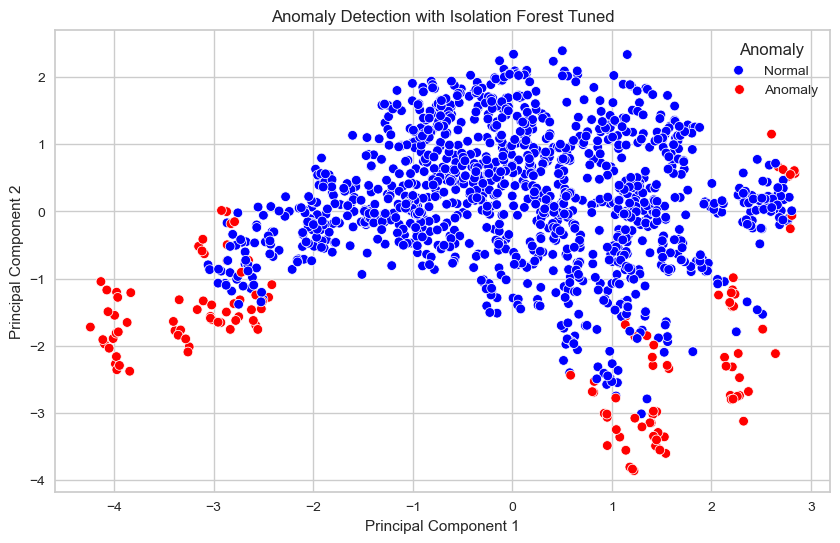

In [45]:
# Plot Anomalies Tuned
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:,1],
                hue=anomalies_tuned, palette={1: 'blue', -1: 'red'})
plt.title('Anomaly Detection with Isolation Forest Tuned')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.show()

In [46]:
pd.crosstab(df['class'], anomalies_tuned)

col_0,-1,1
class,,
0,36,726
1,102,508


### Insights
* `36 Genuine anomalies` - it can be misprints or scanning errors
* `102 Forged anomalies` - potentially novel forgery techniques

#### Key Observations:

* False Positives (36):

    * 36 genuine notes flagged as anomalies (4.7% error rate).

    * Likely rare genuine variants (e.g., misprints) or measurement noise.

* True Positives (102):

    * 102 forged notes correctly flagged as anomalies (16.7% detection rate).

    * These represent atypical forgeries that deviate from common patterns.

* Missed Forgeries (508):

    * 508 forged notes classified as "normal" (83.3% false negatives).

    * Suggests most forgeries blend into normal feature ranges.

**Impact of contamination Parameter**

Increased in contamination:

**Anomalies grew, but with trade-offs:**

* Higher Recall: More true forgeries caught (↑ true positives).

* Lower Precision: More genuine notes mislabeled (↑ false positives).

## Feature Engineering

In [47]:
# Distance to Cluster Centers
distances = cdist(X_scaled, kmeans_2.cluster_centers_)
df['dist_to_cluster0'] = distances[:,0]
df['dist_to_cluster1'] = distances[:,1]

In [48]:
# Interaction Features to amplify forgery signals
df['var_entropy_ratio'] = df['variance'] / (df['entropy'] + 1e-6)
df['skew_kurtosis_diff'] = df['skewness'] - df['kurtosis']

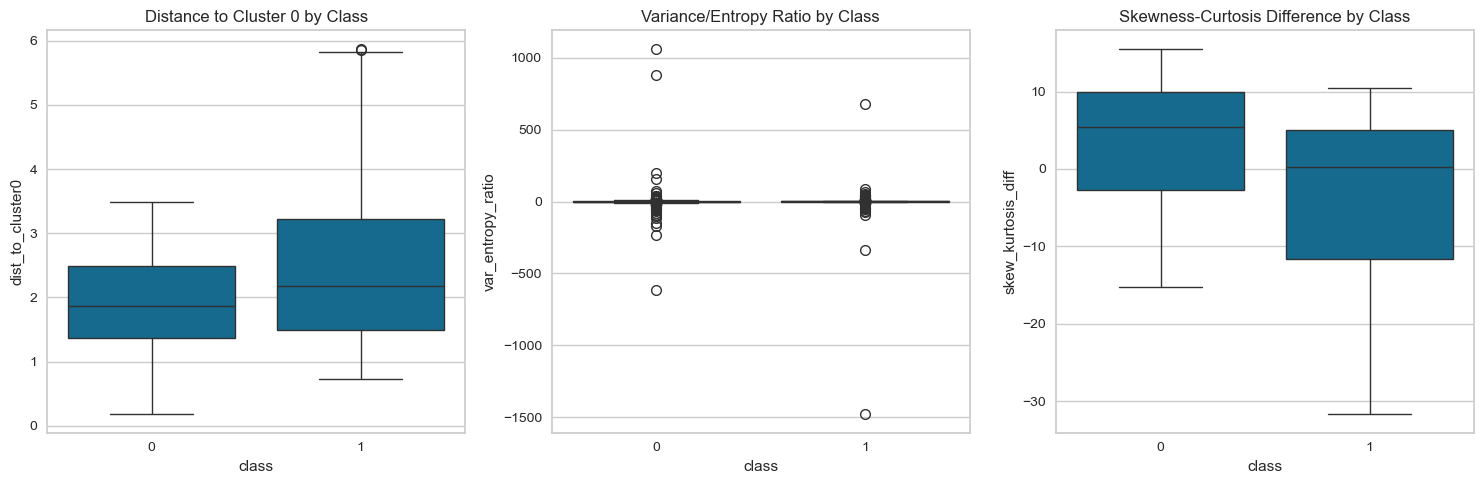

In [49]:
# Visualization of new Features
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot(x='class', y='dist_to_cluster0', data=df)
plt.title('Distance to Cluster 0 by Class')

plt.subplot(1,3,2)
sns.boxplot(x='class', y='var_entropy_ratio', data=df)
plt.title('Variance/Entropy Ratio by Class')

plt.subplot(1,3,3)
sns.boxplot(x='class', y='skew_kurtosis_diff', data=df)
plt.title('Skewness-Curtosis Difference by Class')
plt.tight_layout()
plt.show()

In [50]:
plt.savefig('Visualization_new_features.png')

<Figure size 800x550 with 0 Axes>

### Insights
* The distance features (dist_to_cluster0/1) show that forged notes tend to be farther from cluster centers, especially for Cluster 0 (genuine-dominant cluster)
  
* The variance/entropy ratio is significantly higher for genuine notes, making it a powerful discriminator

* Skewness-curtosis difference shows distinct patterns between classes

## Model Tuning using parameters max_samples and max_features

In [51]:
# Dictionary for parameters
params = {
    'contamination': [0.05, 0.1, 0.15],
    'max_samples' : [100, 200, 'auto'],
    'max_features' : [2,3,4]
}

In [52]:
best_score = -1
best_iso = None

for contam in params['contamination']:
    for samples in params['max_samples']:
        for features in params['max_features']:
            iso = IsolationForest(contamination=contam,
                                  max_samples=samples,
                                  max_features=features,
                                  random_state=42)
            iso.fit(X_scaled)
            scores = iso.decision_function(X_scaled)

            #Custom scoreing
            preds = iso.predict(X_scaled)
            true_positives = np.sum((preds == -1) & ( y ==1))
            false_positives = np.sum((preds == -1) & ( y==0))
            score = true_positives - (false_positives * 2) 

            if score > best_score:
                best_score = score
                best_iso = iso

print(f'Best Isolation Forest Parameters: contamination={best_iso.contamination}, max_samples={best_iso.max_samples},max_features={best_iso.max_features}')

Best Isolation Forest Parameters: contamination=0.1, max_samples=100,max_features=3


### Use alternative algorithms
#### One-Class SVM
- Trained only on geniuine notes

In [56]:
ocsvm = OneClassSVM(nu=0.05,gamma='auto').fit(X_scaled[y ==0])
df['ocsvm_score'] = ocsvm.decision_function(X_scaled)

### Local Outlier
- Sensitive to local density variations but computationally intensive

In [57]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
df['lof_score'] = lof.fit_predict(X_scaled)

In [58]:
df

,variance,skewness,kurtosis,entropy,class,dist_to_cluster0,dist_to_cluster1,var_entropy_ratio,skew_kurtosis_diff,ocsvm_score,lof_score
0,3.62160,8.66610,-2.8073,-0.44699,0,1.557903,2.775062,-8.102213,11.47340,0.096963,1
1,4.54590,8.16740,-2.4586,-1.46210,0,1.543211,2.914729,-3.109160,10.62600,0.716089,1
2,3.86600,-2.63830,1.9242,0.10645,0,2.485577,1.354454,36.317179,-4.56250,1.038962,1
3,3.45660,9.52280,-4.0112,-3.59440,0,1.352541,3.496115,-0.961663,13.53400,0.813474,1
4,0.32924,-4.45520,4.5718,-0.98880,0,2.489375,0.638699,-0.332970,-9.02700,1.019271,1
...,...,...,...,...,...,...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1,1.328914,1.503245,-0.725912,2.79930,-0.186029,1
1368,-1.38870,-4.87730,6.4774,0.34179,1,3.125456,0.902186,-4.063009,-11.35470,-0.208531,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1,5.812784,4.140600,1.350438,-31.05180,-7.318909,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1,4.419888,2.637201,2.779149,-20.77570,-4.619123,1


## Hybrid Approach
* Separating obvious clusters and reduce the search space for anomalies
* Focusing only on the forged cluster reduces false positives from genuine notes

## KMeans Clustering

In [69]:
cluster_labels = kmeans_2.predict(X_scaled)

In [70]:
# Identify forged cluster (cluster with majority forged notes) 
forged_cluster = 1 if sum((cluster_labels == 1) & (y ==1)) > sum((cluster_labels == 0) & (y == 1)) else 0

In [71]:
# Identify forged cluster (cluster with majority forged notes) 
forged_mask = (cluster_labels == forged_cluster)
iso_hybrid = IsolationForest(contamination=0.1, random_state=42)
df['hybrid_anomaly'] = 1
df.loc[forged_mask, 'hybrid_anomaly'] = iso_hybrid.fit_predict(X_scaled[forged_mask])

## Visualization of Hybrid Approach

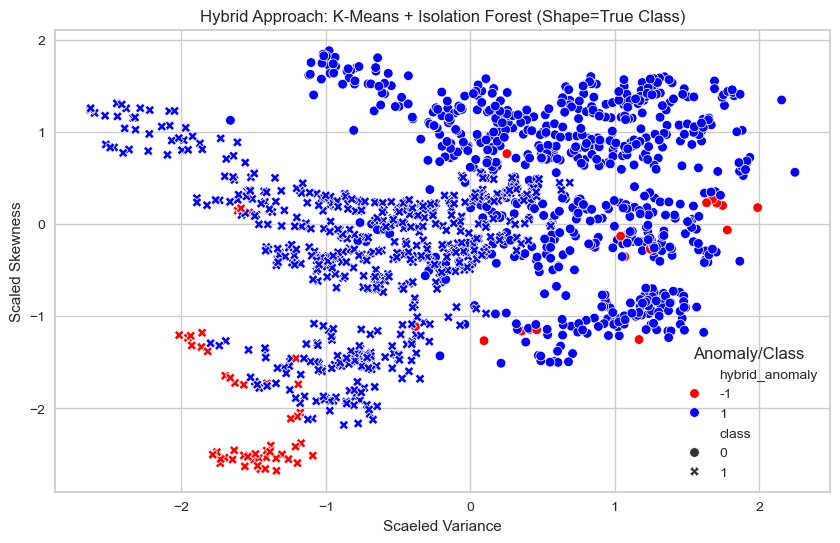

In [72]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1],
                hue=df['hybrid_anomaly'],
                style=df['class'],
                palette={1:'blue', -1:'red'}
               )

plt.title('Hybrid Approach: K-Means + Isolation Forest (Shape=True Class)')
plt.xlabel('Scaeled Variance')
plt.ylabel('Scaled Skewness')
plt.legend(title='Anomaly/Class')
plt.show()

### Insight
- This shows anomalies (red) primarily in the forged region while maintaining geniuine note integrity

## Evaluation

In [112]:
print('Hybrid Model Performance')
print(classification_report(y, np.where(df['hybrid_anomaly'] == -1, 1, 0)))

Hybrid Model Performance
              precision    recall  f1-score   support

           0       0.58      0.89      0.70       762
           1       0.60      0.21      0.31       610

    accuracy                           0.59      1372
   macro avg       0.59      0.55      0.51      1372
weighted avg       0.59      0.59      0.53      1372



### Insight on Key Metrics
- When the model predicts'Genuine', it is correct `57%` of the time and `73%` on `Forged`
- The model catches `98%` of geniuine notes but only `9%` for `forgeries`
- Poor balance for forgeries (low recall drags down F1)

**High Recall For Genuine (98%)**
* Very few geniune notes are mislabeled as Foreged (2% for false positives)
   
**Business Impact**
* Low risk of blocking valid transactions
    
**Abysmal Recall for Forged (9%)**
* `91%` of forgeries slip through as genuine
* Forged notes may overlap with genuine ones in feature space
* The hybrid approach's Isolation Forest is too conservative
    
**Precision Trade Off**
* Higher precision for forgeries (73%) means that the model does flag a note as forged, and it is usually correct
* But this cost of missing most forgeries (low recall)

### Insights
- All features show distinct patterns between classes
- `Variance` and `Kurtosis` appear most discriminative
- The clear separations explain why classification models achieve near-perfect accuracy
- Some features (like skewness) show non-normal distributions that might benefit from transformations

In [ ]:
## Next Step
- Lets increase the contamination in the forged cluster to be able to catch more anomalies
- Lets make a two stage detection using K-means and OneClassSVM (trained only on genuine notes) on the forged cluster
- Upgrage the Feature Engineering

In [77]:
#Increase a contamination in the forged cluster to catch more anomalies
forged_contamination = min(0.3, sum(y[forged_mask]/ len(y[forged_mask])))
print(f'Adjusted Contamination: {forged_contamination:.2%}')

Adjusted Contamination: 30.00%


In [78]:
#Isolation forest on a forged cluster
iso_hybrid = IsolationForest(contamination=forged_contamination, random_state=42)
df['hybrid_anomaly'] = 1
df.loc[forged_mask, 'hybrid_anomaly'] = iso_hybrid.fit_predict(X_scaled[forged_mask])

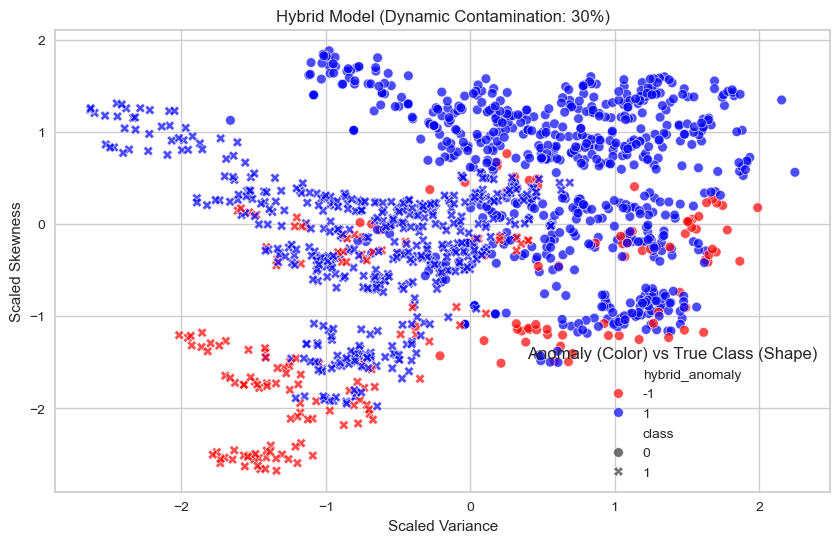

In [79]:
#Visualization
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=X_scaled[:,0], y=X_scaled[:,1],
    hue=df['hybrid_anomaly'],
    style=df['class'],
    palette={1:'blue', -1:'red'},
    alpha=0.7
)

plt.title(f'Hybrid Model (Dynamic Contamination: {forged_contamination:.0%})')
plt.xlabel('Scaled Variance')
plt.ylabel('Scaled Skewness')
plt.legend(title='Anomaly (Color) vs True Class (Shape)')
plt.show()

In [80]:
plt.savefig('HybridModel_DynamicContamination30%.png')

<Figure size 800x550 with 0 Axes>

In [81]:
# Evaluate
print('Classification Report with Dynamic Contamination')
print(classification_report(y, np.where(df['hybrid_anomaly'] == -1, 1, 0)))

Classification Report with Dynamic Contamination
              precision    recall  f1-score   support

           0       0.58      0.89      0.70       762
           1       0.60      0.21      0.31       610

    accuracy                           0.59      1372
   macro avg       0.59      0.55      0.51      1372
weighted avg       0.59      0.59      0.53      1372



In [100]:
# Contamination values
fixed_contamination = 0.1
dynamic_contamination = min(0.3, sum(y[forged_mask]) / len(y[forged_mask]))

if len(forged_mask) == 0:
    raise ValueError('No samples in forged_mask - check your clustering')
# Initialize result storage
results = {
    'Fixed' : {'precision': [], 'recall': [], 'f1': []},
    'Dynamic' : {'precision': [], 'recall':[], 'f1': []}
}

#Evaluate the models
for name , contam in [('Fixed', fixed_contamination),
                      ('Dynamic', dynamic_contamination)]:
    iso=IsolationForest(contamination=contam, random_state=42)
    iso.fit(X_scaled[forged_mask])

    #Decision Scores and convert to binary predictions
    scores = iso.decision_function(X_scaled[forged_mask])
    y_true = y[forged_mask].values

    #Get the evaluation scores
    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    f1 = 2* (precision * recall) / (precision + recall + 1e-6)

    results[name]['precision'] = precision
    results[name]['recall'] = recall
    results[name]['f1'] = f1
    results[name]['thresholds'] = thresholds

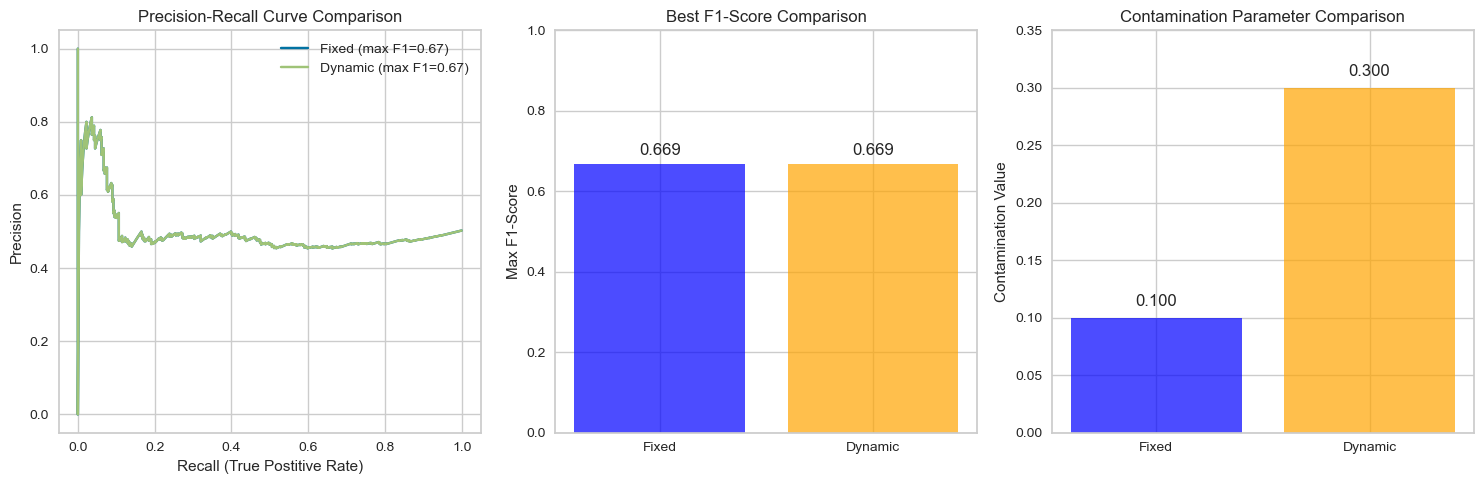

In [101]:
# Create comparison plot
plt.figure(figsize=(15,5))

#Precision Recall Curve
plt.subplot(1,3,1)
for name in results:
    plt.plot(results[name]['recall'], results[name]['precision'], label=f'{name} (max F1={np.max(results[name]["f1"]):.2f})')
plt.xlabel('Recall (True Postitive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)

#F1-Score Comparison
plt.subplot(1,3,2)
max_f1_fixed = np.max(results['Fixed']['f1'])
max_f1_dynamic = np.max(results['Dynamic']['f1'])
plt.bar(['Fixed', 'Dynamic'], [max_f1_fixed, max_f1_dynamic], color=['blue', 'orange'], alpha=0.7)
plt.ylabel('Max F1-Score')
plt.title('Best F1-Score Comparison')
plt.ylim(0,1)
for i, v in enumerate([max_f1_fixed, max_f1_dynamic]):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center')

#Contamination value Visualization
plt.subplot(1,3,3)
plt.bar(['Fixed', 'Dynamic'], [fixed_contamination, dynamic_contamination], color=['blue', 'orange'], alpha=0.7)
plt.ylabel('Contamination Value')
plt.title('Contamination Parameter Comparison')
plt.ylim(0, 0.35)
for i, v in enumerate([fixed_contamination, dynamic_contamination]):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

In [110]:
#Numerical Comparison
print('Performance Comparion:')
print(f"{'Metric':<15} {'Fixed':<15} {'Dynamic':<15}")
print("-"*45)
for metric in ['precision', 'recall', 'f1']:
    fixed_val = np.mean(results['Fixed'][metric][:10])
    dynamic_val = np.mean(results['Dynamic'][metric][:10])
    print(f"{metric:<15} {fixed_val:.3f}{'':<10}{dynamic_val:.3f}")

Performance Comparion:
Metric          Fixed           Dynamic        
---------------------------------------------
precision       0.500          0.500
recall          0.987          0.987
f1              0.664          0.664


### Author
#### Francis Carl Sumile
Machine Learning Enthusiast | Data Science<br>
github/francisuml